In [2]:
from PIL import Image
import pytesseract
import glob
import numpy as np
import cv2
import re
import pdfplumber
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = [20, 10]

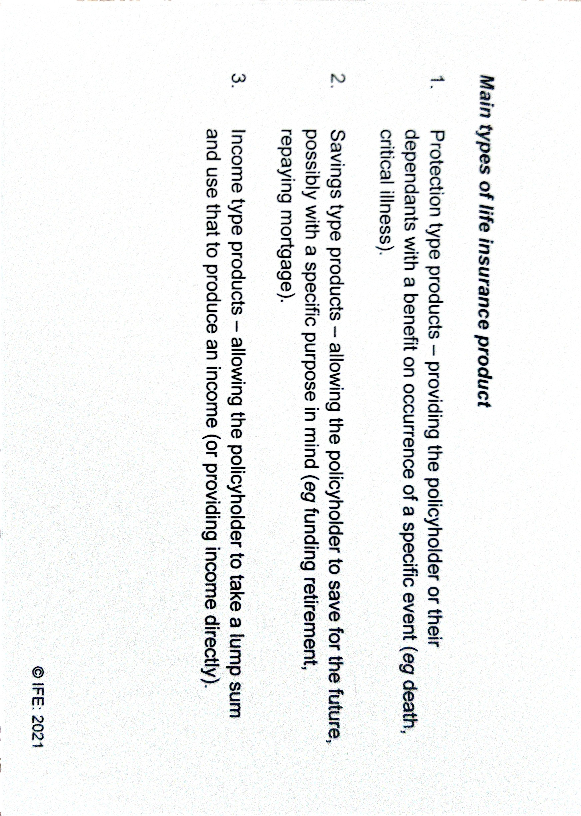

In [3]:
with pdfplumber.open('fc2022.pdf') as pdf:
    pages = pdf.pages
    impages = [p.to_image(resolution=70) for p in pages]
impages[0]

In [5]:
for i,p in enumerate(impages):
    p.save(f'scans/{i}.png', format="PNG")

In [6]:
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    #gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(newImage, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
#     allContourAngles = [cv2.minAreaRect(c)[-1] for c in contours]
#     angle = sum(allContourAngles) / len(allContourAngles)
    if angle < -45:
        angle = 90 + angle
    if angle > 45:
        angle = angle - 90
    return -1.0 * angle

# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [8]:
def contrast(cvImage):
    newImage = cvImage.copy()
    newImage[newImage > 180] = 255
    newImage[newImage < 90] = 0
    return newImage

def ocrprep(cvImage):
    newImage = cvImage.copy()
    return contrast(deskew(newImage))

def ocr(path):
    imcv = cv2.imread(path, 0)
    prep = ocrprep(imcv)
    return pytesseract.image_to_string(prep,config='--oem 3 --psm 6')

def ocr_90(path):
    imcv = cv2.imread(path, 0)
    rotimcv = rotateImage(imcv,-90)
    prep = ocrprep(rotimcv)
    return pytesseract.image_to_string(prep,config='--oem 3 --psm 6')

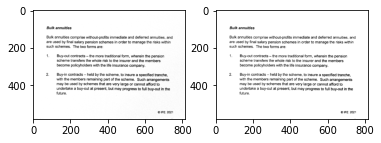

In [13]:
imcv = cv2.imread(glob.glob('scans/*')[146], 0)

plt.subplot(1, 2, 1)
plt.imshow(imcv, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(ocrprep(imcv), cmap='gray')

In [15]:
rev1d = [ocr(p) for p in glob.glob('scans/*')]

In [16]:
with open('fcs.txt','w') as f:
    f.write('\n----------\n'.join(rev1d))